In [416]:
import datetime

import pandas as pd

# load a time series of univariate data
# for now just load this one dataset https://raw.githubusercontent.com/waico/SKAB/master/data/valve1/2.csv

# load the dataset (; separated)
series = pd.read_csv(
	'https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_GOOG.csv', header=0,
	index_col=0, parse_dates=True, delimiter=',')

In [417]:
# show the first few rows of the dataset
print(series.head(2))

                     value
timestamp                 
2015-02-26 21:42:53     35
2015-02-26 21:47:53     41


In [418]:
# instead, let's generate a dataset where the data follows a more interesting pattern
# and then we can add some noise to it
# pattern: y = 2x^2 + 300
# noise: normal distribution with mean 0 and std dev 1

import numpy as np
import datetime

base_data = np.array([2 * i * i + 300000 for i in range(1000)])

# add noise
noise = np.random.normal(100000, 100000, 1000)
noisy_data = base_data + noise

# add some anomalies
# at each point, 5% chance of failed sensor reading (0)
for i in range(1000):
	if np.random.rand() < 0.05:
		noisy_data[i] = 0

# create a time series
series = pd.DataFrame(noisy_data, index=[datetime.datetime.now() + datetime.timedelta(seconds=i) for i in range(1000)])

# set the column name
series.columns = ["value"]



In [419]:
# convert timestamps to # of seconds since first observations
first_observation = series.index.min()

series.index = series.index.map(lambda x: (x - first_observation).seconds)


In [420]:
series.index

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       990, 991, 992, 993, 994, 995, 996, 997, 998, 999],
      dtype='int64', length=1000)

In [421]:
series.head()

,value
0,540583.526636
1,519460.148718
2,335378.532929
3,467728.404330
4,465533.025082


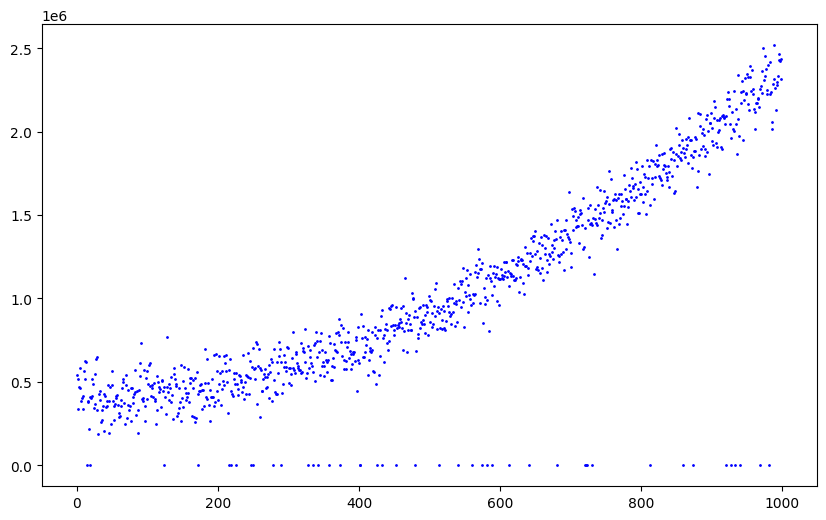

In [422]:
import matplotlib
from datetime import datetime
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Adjusts the figure size

plt.scatter(series.index, series[series.columns[0]], color="blue",
			s=1)
# plt.yscale("log")
plt.show()

In [423]:
# this should be a really simple example. Let's start by finding the line of best fit

import numpy as np

n = 3
coefficients = np.polyfit(series.index, series.values, n)

# m, b = np.polyfit(series.index, series.values, 1)


In [424]:
# print("m: ", m, "b: ", b)

In [425]:
# plot that line
x_line = np.linspace(series.index.min(), series.index.max(), 100)  # More points for a smoother line
y_line = np.polyval(coefficients, x_line)

std_dev = np.std(series.values)


def expected_value(value):
	return np.polyval(coefficients, value)[0]


def is_anomaly(entry):
	expectation = expected_value(entry[0])
	diff = abs(expectation - entry[1]).values[0]
	# print("diff type", type(diff), "equals", diff)
	# print("expectation type", type(expectation), "equals", expectation)
	result = bool((diff > std_dev) or (diff > 0.9 * expectation))
	# print("result", result)
	return result


In [426]:
anomalies = [v for v in series.iterrows() if is_anomaly(v)]
non_anomalies = [v for v in series.iterrows() if not is_anomaly(v)]

In [427]:
def timestamp_value_list_x_y(input_list):
	x = [v[0] for v in input_list]
	y = [v[1] for v in input_list]
	return x, y

C:\Users\Ezra\AppData\Local\pypoetry\Cache\virtualenvs\cs365-DQ18TMOT-py3.9\lib\site-packages\matplotlib\cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


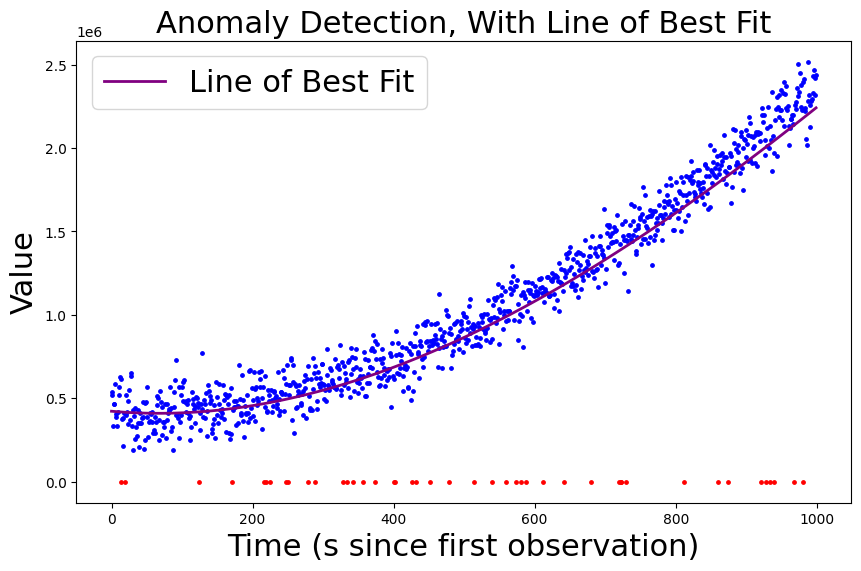

In [428]:
plt.show()

plt.figure(figsize=(10, 6))  # Optional: Adjusts the figure size
plt.plot(x_line, y_line, color='purple', label='Line of Best Fit', linewidth=2)

# Plots normal points in blue and anomalies in red
x_values, y_values = timestamp_value_list_x_y(non_anomalies)
x_anom_values, y_anom_values = timestamp_value_list_x_y(anomalies)
# plt.yscale("log")
plt.scatter(x_values, y_values, color="blue", s=6)
plt.scatter(x_anom_values, y_anom_values, color="red", s=6)

fontsize = 22

plt.xlabel("Time (s since first observation)", fontsize=fontsize)
plt.ylabel("Value", fontsize=fontsize)
plt.title("Anomaly Detection, With Line of Best Fit", fontsize=fontsize)
# increase font size
plt.legend(fontsize=22)


SKAB v0.9
- A number of datasets: 34
- Shape of the random dataset: (1147, 10)
- A number of changepoints: 129
- A number of outliers (point anomalies): 13067

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-01 15:44:06,0.082065,0.133521,1.27794,0.054711,92.2562,22.2577,209.639,76.0197,0.0,0.0


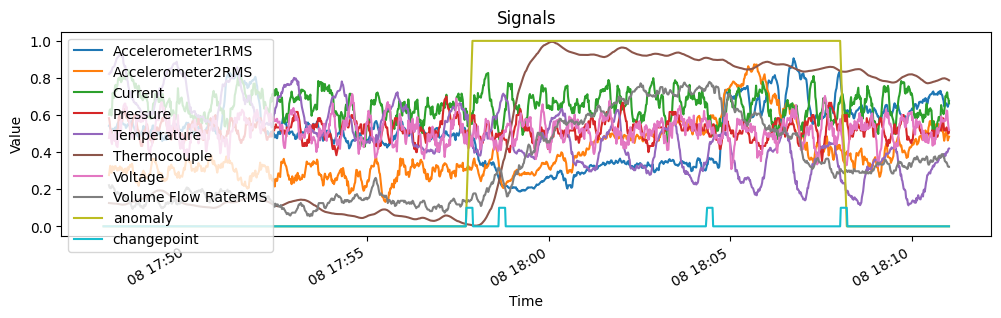

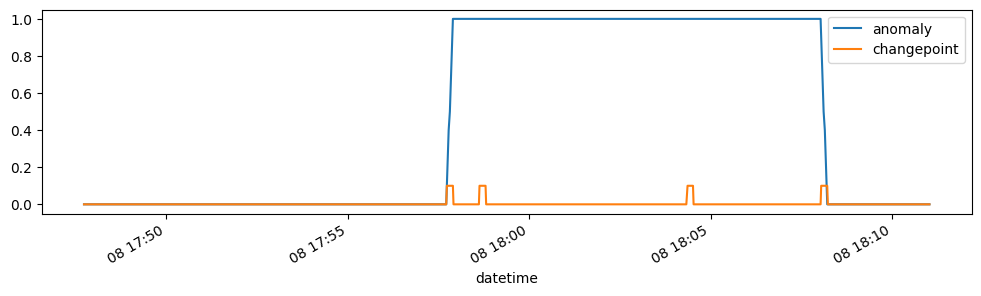

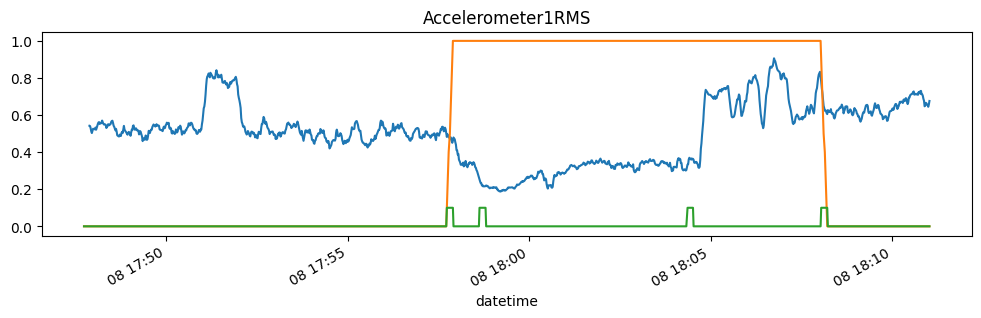

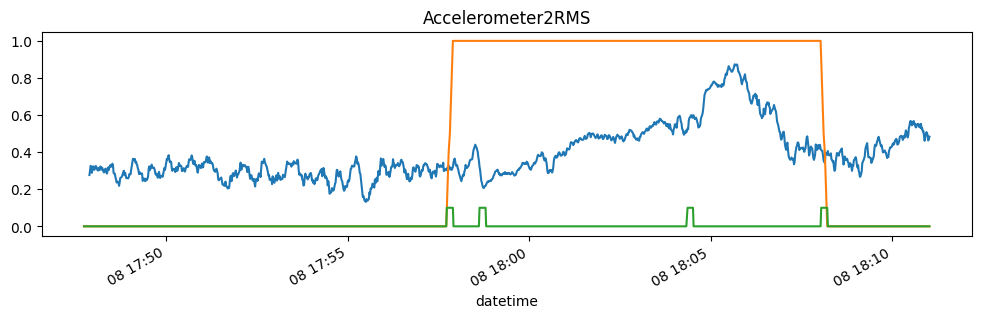

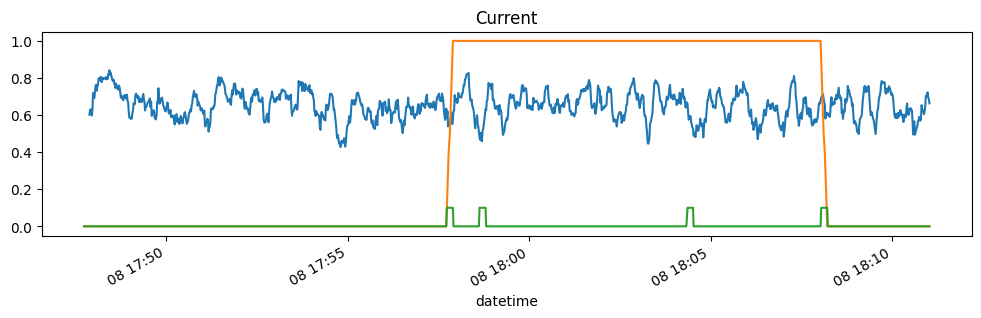

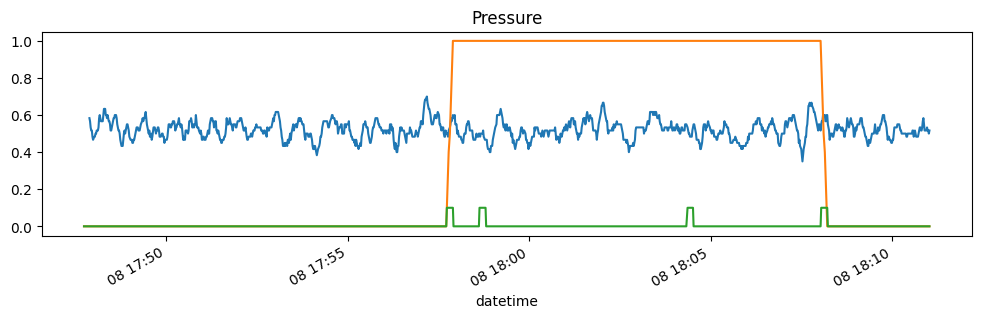

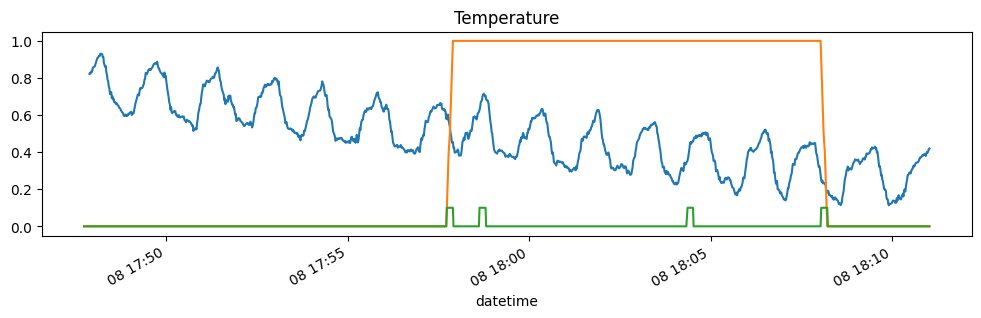

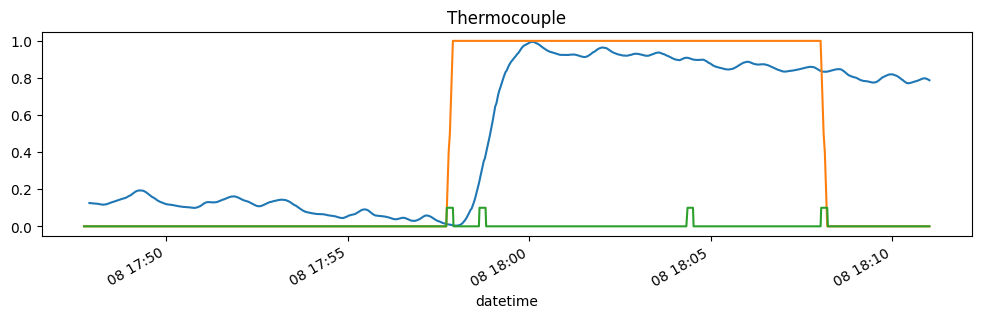

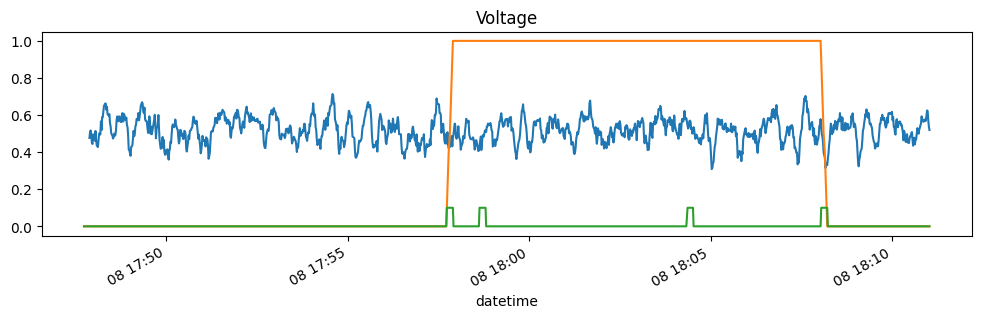

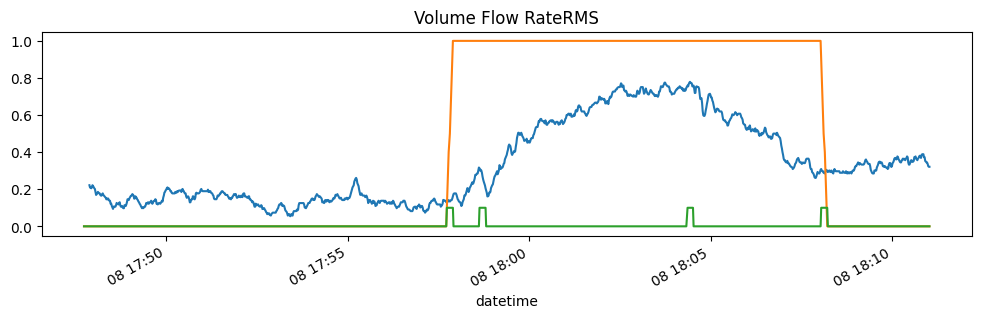

In [18]:
# load data from SKAB
# libraries importing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# additional modules
import sys

sys.path.append('../algorithms')

import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

path_to_data = './SKAB/data/'
## Data loading
# benchmark files checking
all_files = []
import os

for root, dirs, files in os.walk(path_to_data):
	for file in files:
		if file.endswith(".csv"):
			all_files.append(os.path.join(root, file))
# datasets with anomalies loading
list_of_df = [pd.read_csv(file,
						  sep=';',
						  index_col='datetime',
						  parse_dates=True) for file in all_files if 'anomaly-free' not in file]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0],
							  sep=';',
							  index_col='datetime',
							  parse_dates=True)
### Data description
# dataset characteristics printing
print('SKAB v0.9')
print(f'- A number of datasets: {len(list_of_df)}')
print(f'- Shape of the random dataset: {list_of_df[10].shape}')
n_cp = sum([len(df[df.changepoint == 1.]) for df in list_of_df])
n_outlier = sum([len(df[df.anomaly == 1.]) for df in list_of_df])
print(f'- A number of changepoints: {n_cp}')
print(f'- A number of outliers (point anomalies): {n_outlier}\n')
print(f'Head of the random dataset:')

# rescale each series to be in [0, 1] range
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
list_of_df[1] = pd.DataFrame(scaler.fit_transform(list_of_df[1]),
							 columns=list_of_df[1].columns,
							 index=list_of_df[1].index)
# downsample the dataset to a moving average
# but first, make a copy of the original anomaly and changepoint columns
list_of_df[1]['anomaly'] = list_of_df[1]['anomaly'].copy()
list_of_df[1]['changepoint'] = list_of_df[1]['changepoint'].copy()
# downsample the dataset to a moving average
list_of_df[1] = list_of_df[1].rolling(window=10).mean()
# reset the anomaly and changepoint columns
list_of_df[1]['anomaly'] = list_of_df[1]['anomaly'].fillna(0)
list_of_df[1]['changepoint'] = list_of_df[1]['changepoint'].fillna(0)

display(list_of_df[0].head(1))
### Data visualization
# random dataset visualizing
list_of_df[1].plot(figsize=(12, 3))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')

plt.show()
### Labels visualization
# plotting the labels both for outlier and changepoint detection problems
list_of_df[1].anomaly.plot(figsize=(12, 3))
list_of_df[1].changepoint.plot()

plt.legend()
plt.show()

# plot each column individually
# except for the anomaly and changepoint columns, which should be on every plot
for column in list_of_df[1].columns:
	if column not in ['anomaly', 'changepoint']:
		list_of_df[1][column].plot(figsize=(12, 3))
		list_of_df[1].anomaly.plot()
		list_of_df[1].changepoint.plot()
		plt.title(column)
		plt.show()

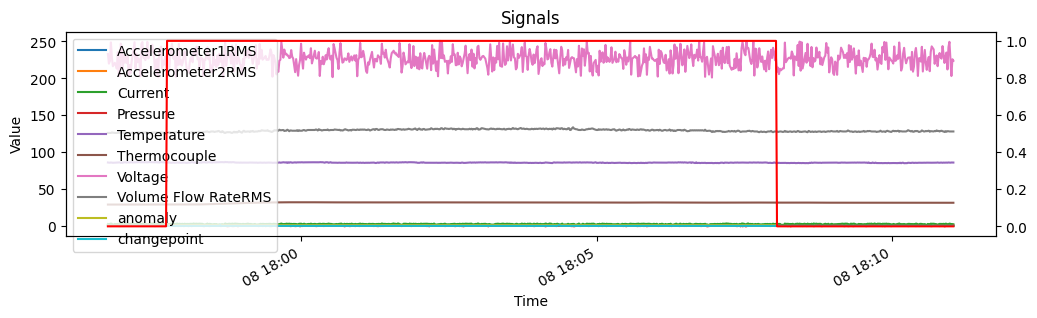

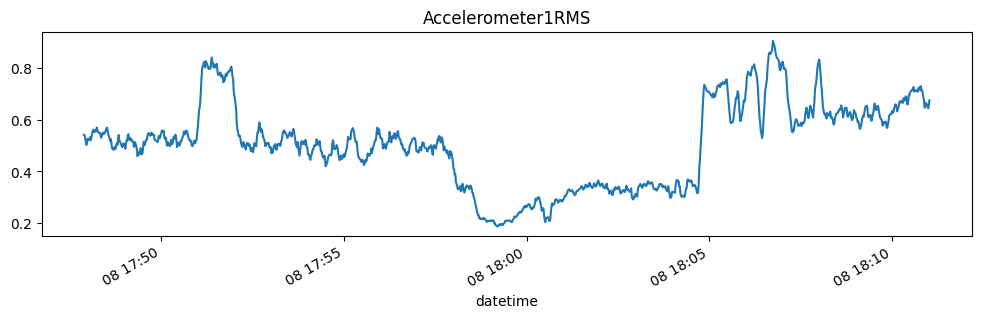

In [33]:
import matrixprofile as mp

# create a matrix profile of series 1
# plot list_of_df[1]['Accelerometer1RMS']
list_of_df[1]['Accelerometer1RMS'].plot(figsize=(12, 3))
plt.title('Accelerometer1RMS')
plt.show()

In [42]:
len(list_of_df[1]['Accelerometer1RMS'])

1327

In [68]:
# remove the NaN values from the series
d = list_of_df[1]['Accelerometer1RMS'].dropna()
len(d)

1318

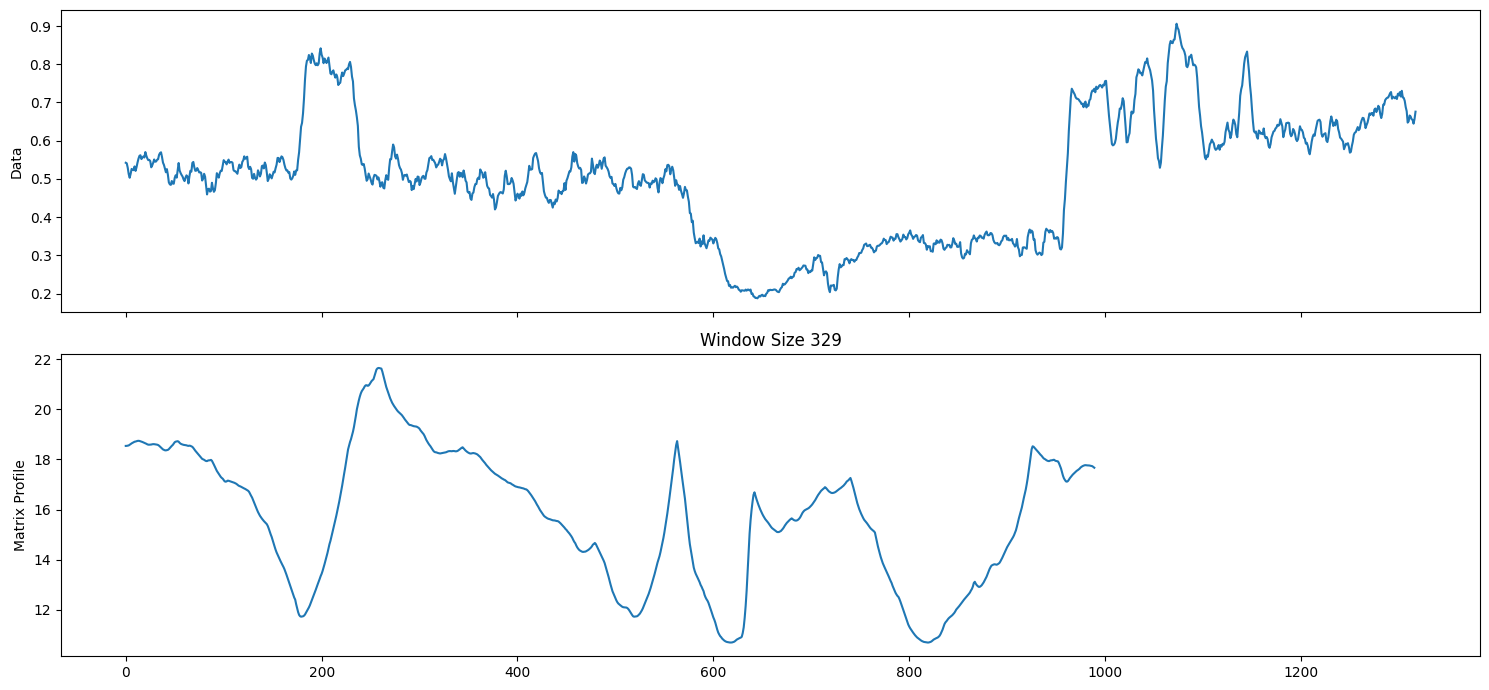

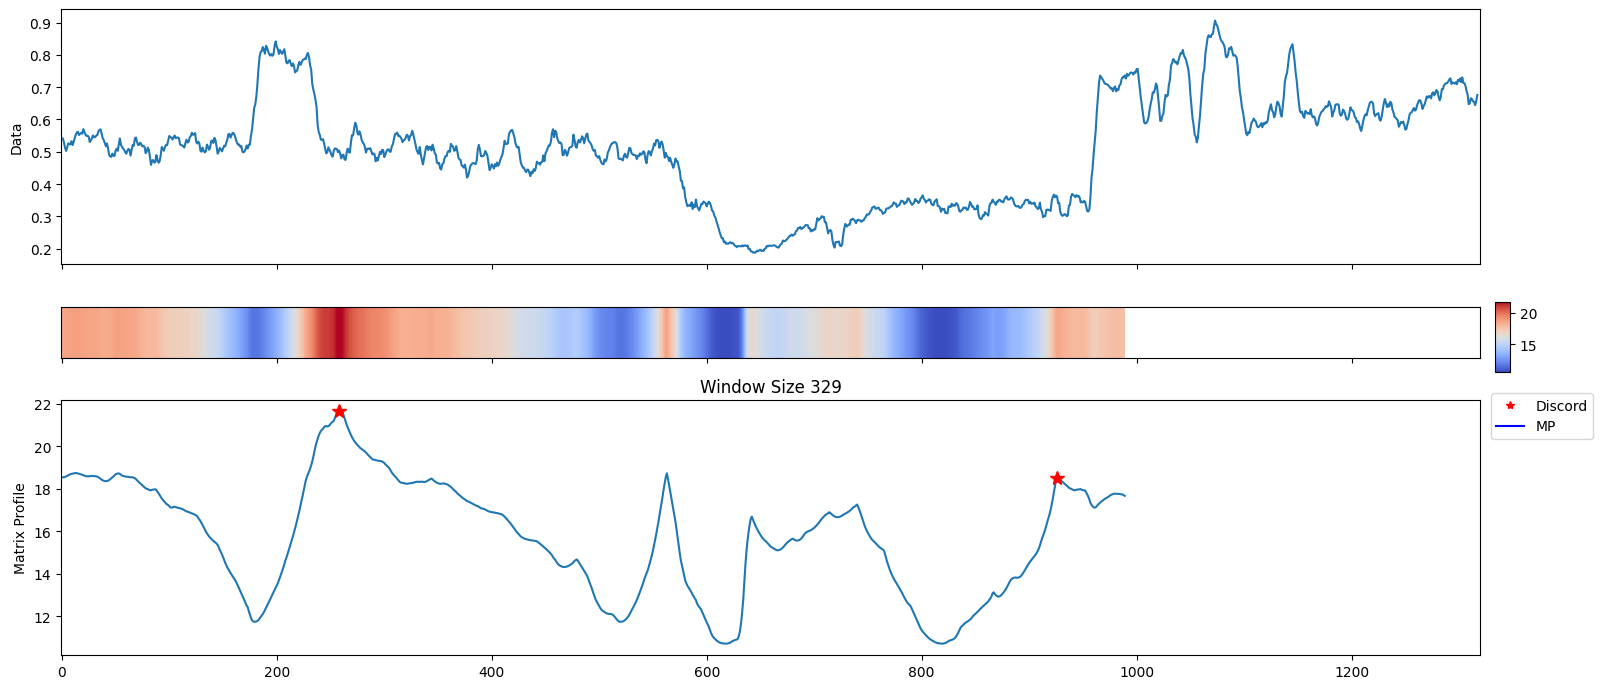

In [107]:
# create a matrix profile of the series
window_size = len(d.values) // 4
profile = mp.compute(d.values, windows=window_size)

profile = mp.discover.discords(profile, k=2, exclusion_zone=window_size)

# profile = mp.discover.discords(profile, k=1, exclusion_zone=100)
mp.visualize(profile)
plt.show()

258
2020-02-08 17:52:25
926
2020-02-08 18:04:10


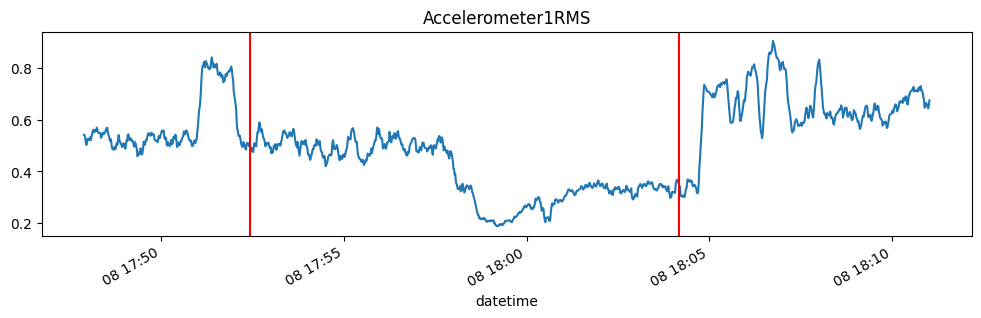

In [109]:
# show the discord on the original series
list_of_df[1]['Accelerometer1RMS'].plot(figsize=(12, 3))
plt.title('Accelerometer1RMS')
# discord index is?
for i in range(len(profile['discords'])):
	discord_index = profile['discords'][i]
	print(discord_index)
	# get the timestamp at the discord index
	discord_timestamp = d.index[discord_index]
	print(discord_timestamp)
	# plot the discord
	plt.axvline(discord_timestamp, color='red')
plt.show()

[<Figure size 1000x1000 with 1 Axes>,
 <Figure size 1500x700 with 4 Axes>,
 <Figure size 1500x700 with 4 Axes>]

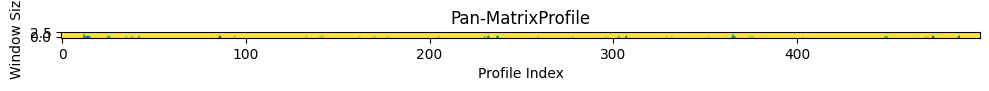

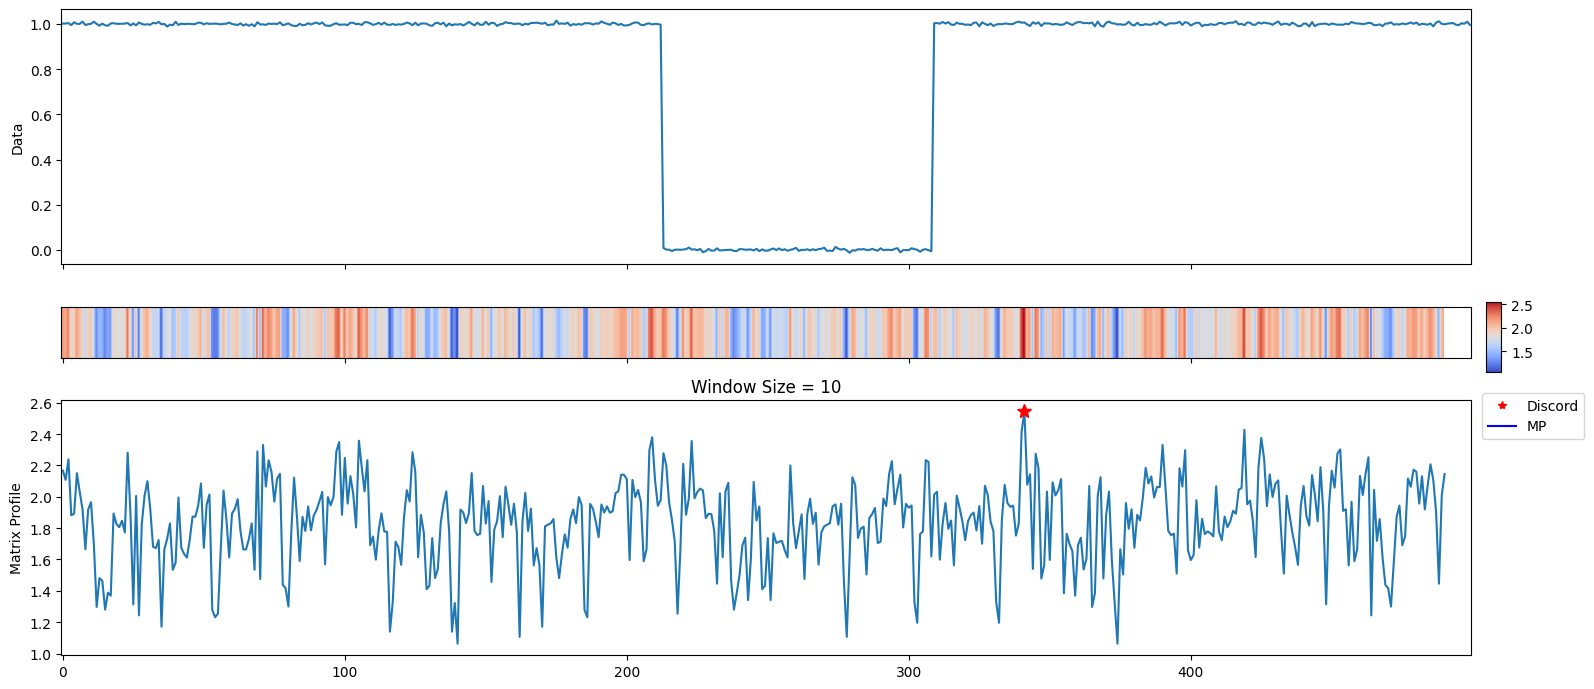

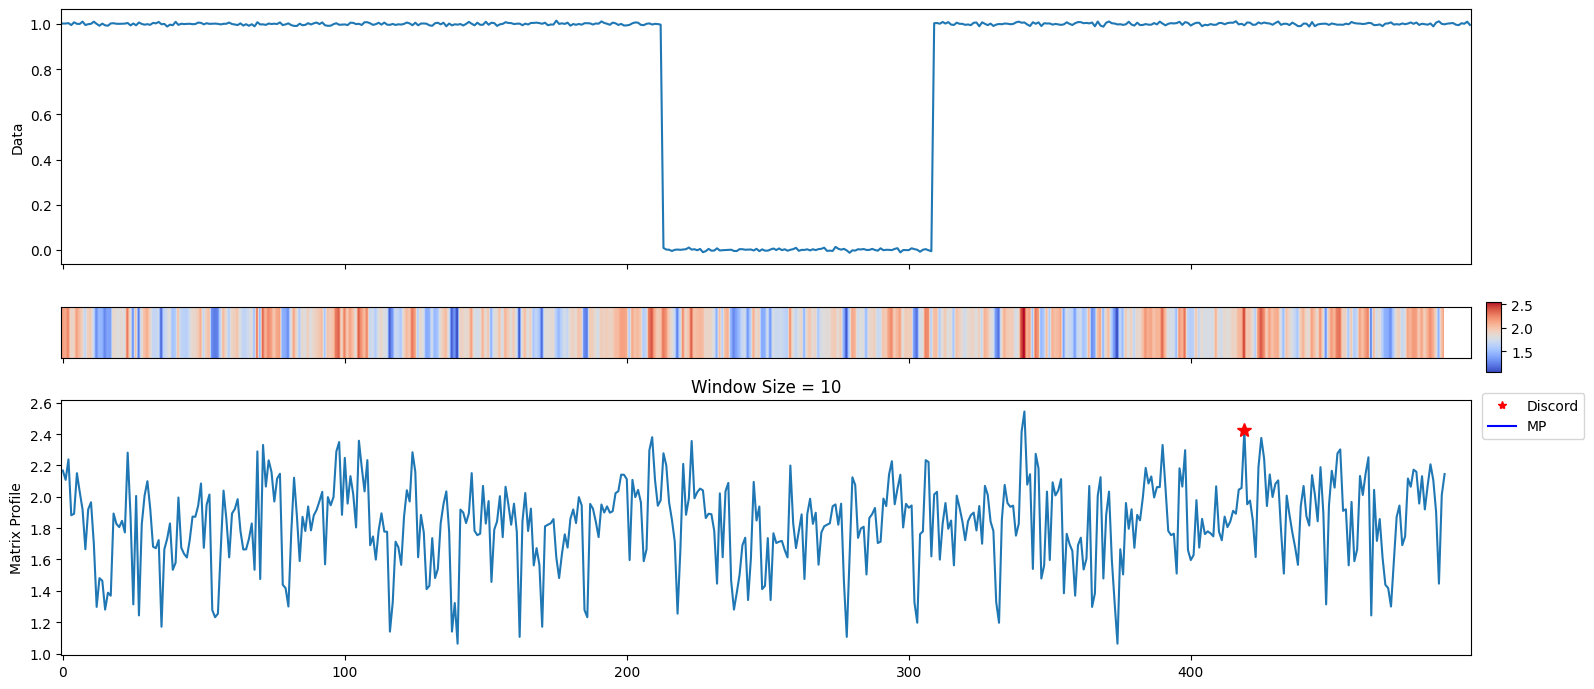

In [156]:
# create an artificial dataset with a discord
import numpy as np

# should be 1 in [0, 200] and 0 in [200, 300], and then 1 again in [300, 500]

# create the time series
time_series = np.zeros(500)
time_series[0:213] = 1
time_series[213:309] = 0
time_series[309:500] = 1

# add a tiny bit of noise
time_series += np.random.normal(0, 0.005, 500)

# window_count = 10
# window_size = len(time_series) // window_count

# create the matrix profile
profile = mp.compute(time_series,
					 # windows=window_count
					 )

# find the discord
profile = mp.discover.discords(profile, k=2,
							   # exclusion_zone=window_size
							   )

# visualize the matrix profile
mp.visualize(profile)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

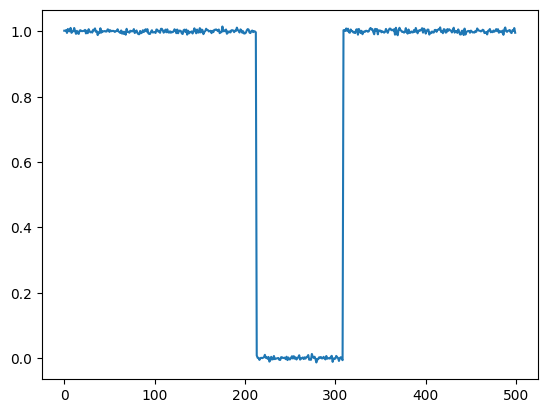

In [157]:

# plot the time series with the discord marked
plt.plot(time_series)
for i in range(len(profile['discords'])):
	discord_index = profile['discords'][i]
	plt.axvline(discord_index, color='red')
	# shade the area around the discord (window size)
	plt.axvspan(discord_index - window_size / 2, discord_index + window_size / 2, color='red', alpha=0.2)


{'motifs': [200, 206], 'neighbors': [200, 200, 200, 200, 200, 200, 200, 200, 200, 200]}
{'motifs': [200, 206], 'neighbors': [200, 200, 200, 200, 200, 200, 200, 200, 200, 200]}
{'motifs': [200, 206], 'neighbors': [200, 200, 200, 200, 200, 200, 200, 200, 200, 200]}
{'motifs': [200, 206], 'neighbors': [200, 200, 200, 200, 200, 200, 200, 200, 200, 200]}


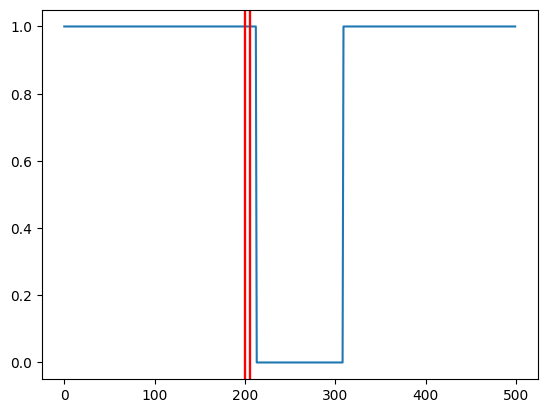

In [153]:
# show the plot with the motifs marked
# find the motifs
profile = mp.discover.motifs(profile, k=4)

# visualize the matrix profile
# mp.visualize(profile)

# plot the time series with the motifs marked
plt.plot(time_series)
for i in range(len(profile['motifs'])):
	motif_index = profile['motifs'][i]
	print(motif_index)
	plt.axvline(motif_index["motifs"][0], color='red')
	plt.axvline(motif_index["motifs"][1], color='red')

In [179]:
# Example data
d = list_of_df[1]['Accelerometer1RMS'].values
d = d[~np.isnan(d)]
data = {
	'value': d
}

len(df)

1318

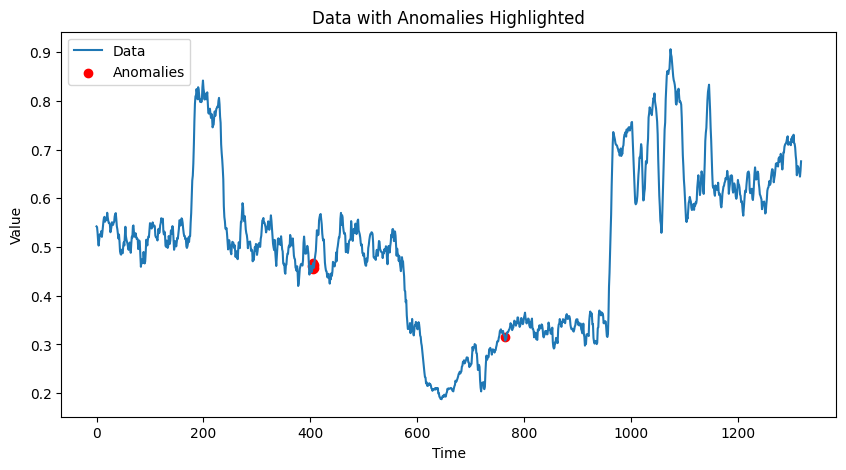

In [183]:
# len(df) = 1319

df = pd.DataFrame(data)

# Set the window size
window_size = len(df) // 8

# Calculate the matrix profile
profile = mp.compute(df['value'].values, windows=window_size)
profile = mp.discover.discords(profile, k=6)  # 'k' is the number of discords/anomalies you want to find

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(df['value'], label='Data')

# Highlight anomalies
anomalies = profile['discords']
plt.scatter(anomalies, df['value'].iloc[anomalies], color='r', label='Anomalies')

plt.legend()
plt.title('Data with Anomalies Highlighted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


In [292]:
import heapq

# let's do it ourselves
# we will iterate over the series and find the relevant discords
# who cares about efficiency, we will brute force

data = list_of_df[1]['Accelerometer1RMS'].values
data = data[~np.isnan(data)]


# artificial data
# data = time_series


# slide = 1
# window_size = len(data) // 5
# ignore_zone = window_size


def get_profile(data, window_size, ignore_zone=None, slide=1):
	if ignore_zone is None:
		ignore_zone = window_size

	profile = [1000000000] * len(data)

	window_halfstep = window_size // 2

	# iterate over the series
	for i in range(window_halfstep, len(data) - window_halfstep, slide):
		# window is centered around the current index
		window = data[i-window_halfstep:i + window_halfstep]

		# calculate the matrix profile by hand
		for j in range(window_halfstep, len(data) - window_halfstep, slide):
			# ignore the zone around the window
			if abs(i - j) < ignore_zone/2:
				continue
			# calculate the distance between the windows

			# distance = np.linalg.norm(window - data[j:j+window_size])
			# we can use the euclidean distance squared so we don't need to take the square root
			# just x x.T
			subsection = data[j-window_halfstep:j + window_halfstep]
			diff = window - subsection
			distance = np.dot(diff, diff.T)
			# update the profile
			profile[i] = min(profile[i], distance)
	# remove all the unreplaced values
	profile = [x for x in profile if x != 1000000000]

	return profile

def highlight_discords(data, profile, percentile=90):
	plt.plot(data, label='Data')
	plt.legend()
	# highlight the discords (regions with top 10th percentile of distances)
	threshold = np.percentile(profile, percentile)
	for i in range(len(profile)):
		if profile[i] > threshold:
			plt.axvline(i, color='red', alpha=0.01, linewidth=1)

In [285]:
p = get_profile(data, len(data) // 5)

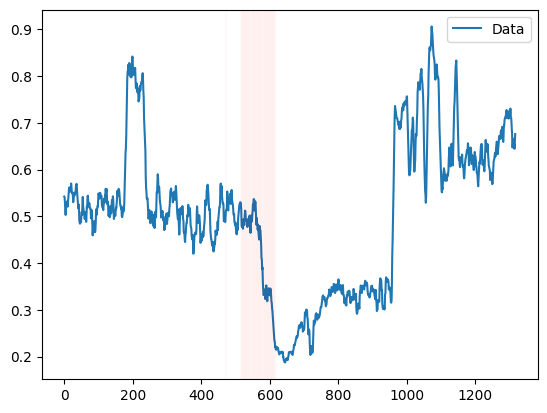

In [287]:
highlight_discords(data, p)
plt.show()

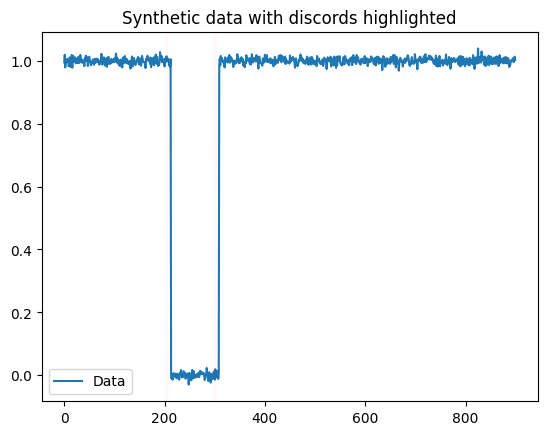

In [305]:
# try on synthetic data
p = get_profile(time_series, len(time_series) // 50)
highlight_discords(time_series, p, 99)
plt.title('Synthetic data with discords highlighted')
plt.show()

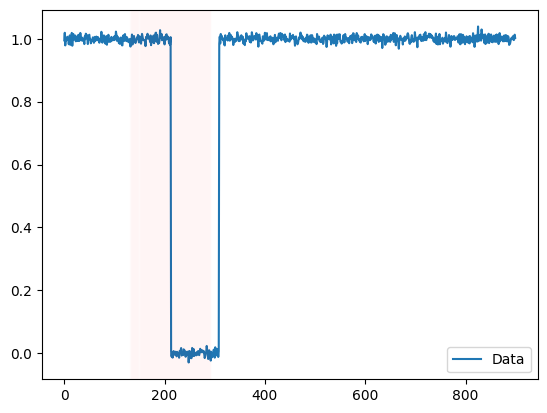

In [302]:
# try with discord length 150 to detect the entire anomalous region
# extend the dataset with another 400 samples
# create the time series
time_series = np.zeros(900)
time_series[0:213] = 1
time_series[213:309] = 0
time_series[309:900] = 1

# add some noise
time_series += np.random.normal(0, 0.01, 900)

p = get_profile(time_series, 100)
highlight_discords(time_series, p, 80)

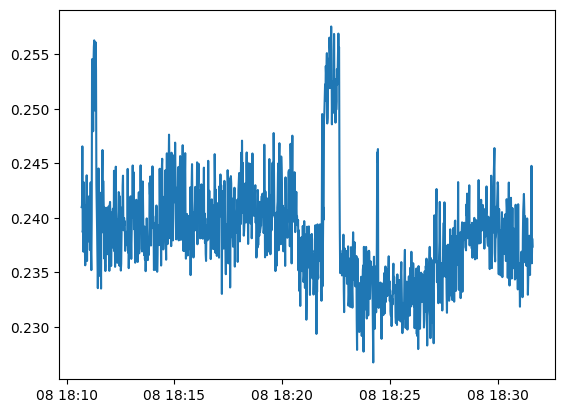

In [280]:
# show list_of_df[2] plot
plt.plot(list_of_df[2]['Accelerometer1RMS'])

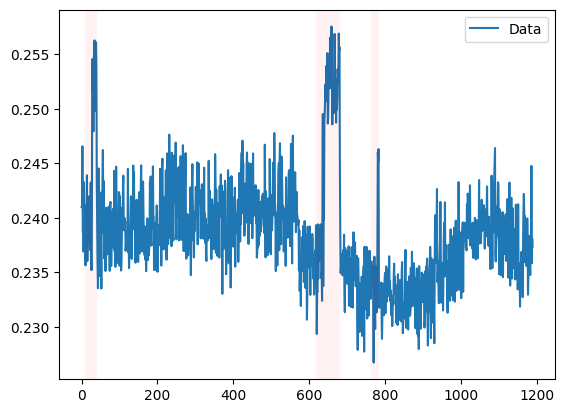

In [281]:
# try on list_of_df[2]
df2_a1_vals = list_of_df[2]['Accelerometer1RMS'].values

p = get_profile(df2_a1_vals, len(df2_a1_vals) // 50)
highlight_discords(df2_a1_vals, p)

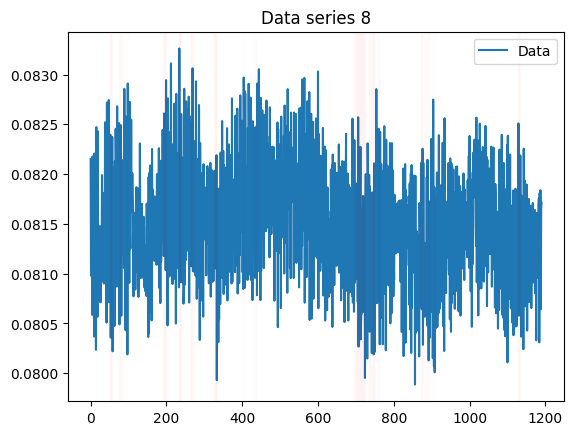

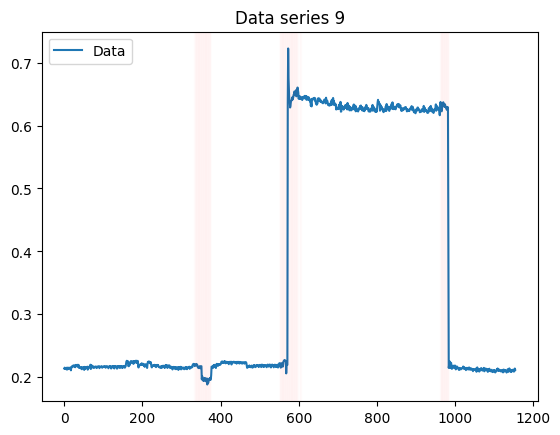

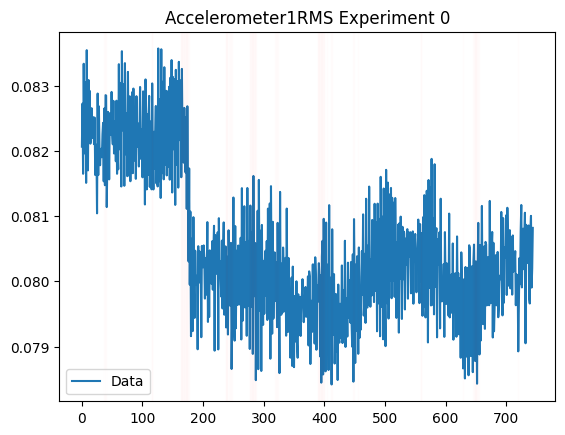

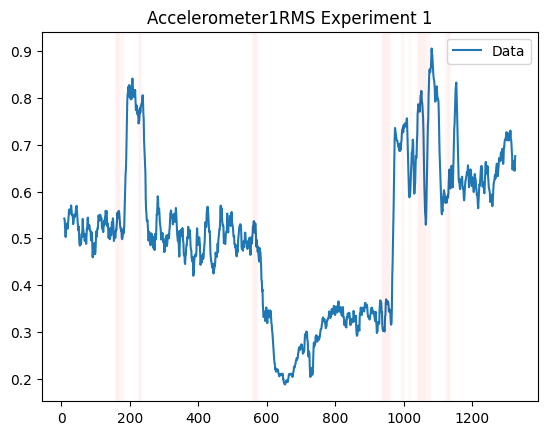

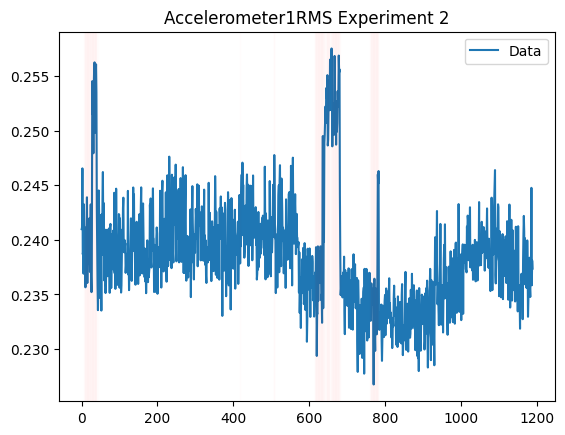

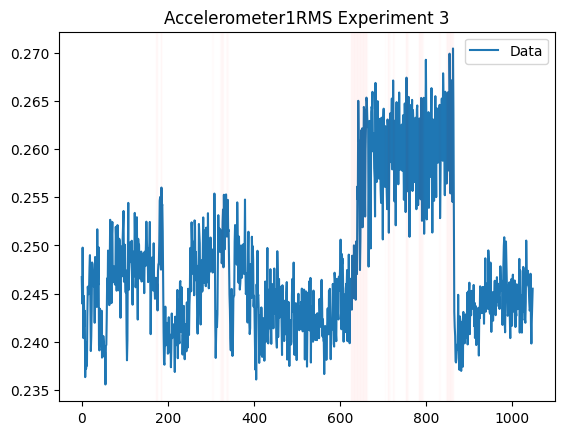

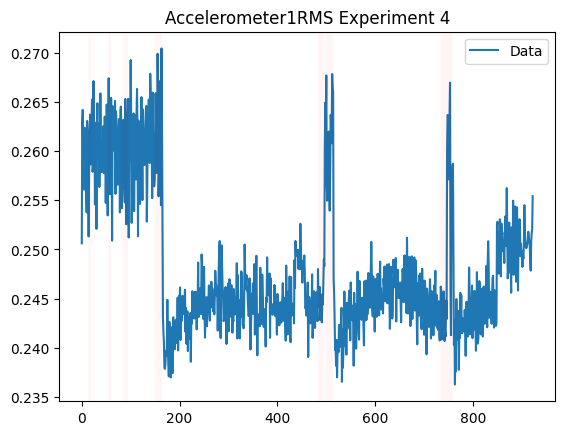

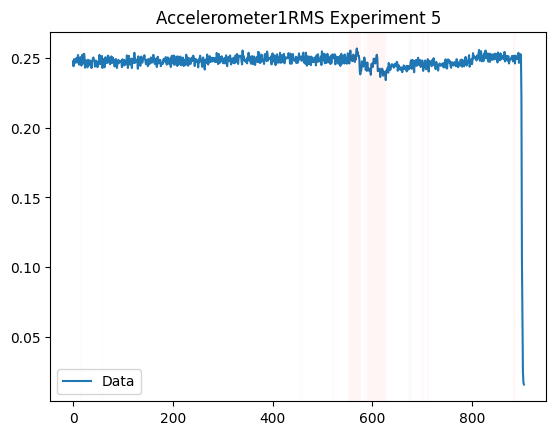

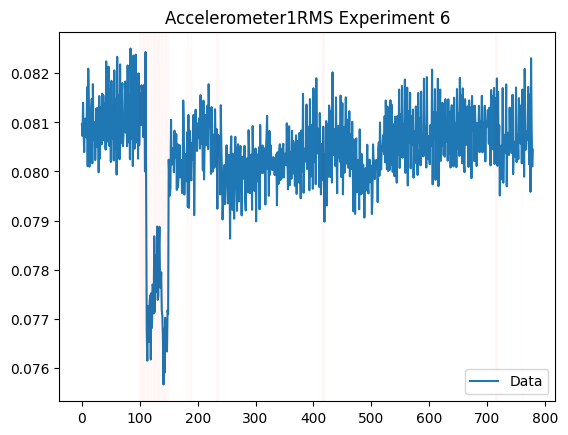

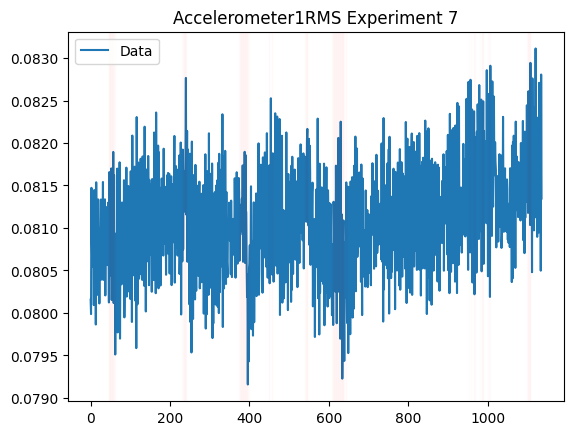

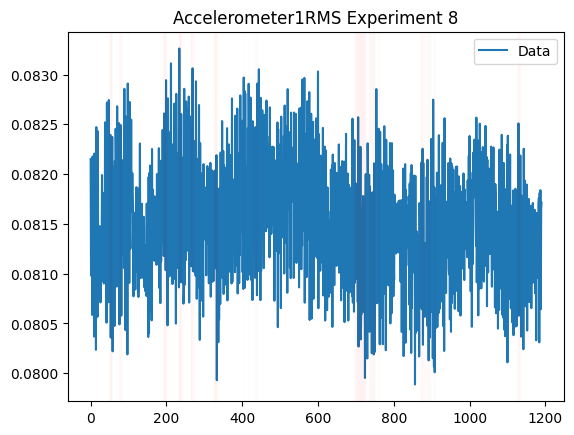

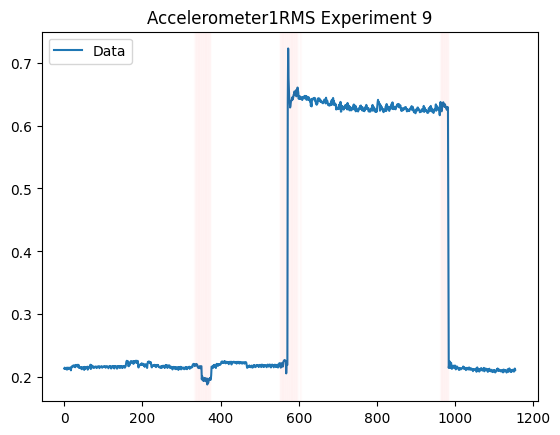

In [304]:
# try on a bunch of different data series

for i in range(10):
	plt.figure()
	df2_a1_vals = list_of_df[i]['Accelerometer1RMS'].values
	p = get_profile(df2_a1_vals, len(df2_a1_vals) // 50)
	highlight_discords(df2_a1_vals, p)
	plt.title(f"Accelerometer1RMS Experiment {i}")
	plt.show()